In [18]:
from __future__ import annotations

import operator
from typing import TypedDict, List, Annotated

from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from dotenv import load_dotenv


from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
import os

In [19]:
class Task(BaseModel):
    id: int
    title: str
    brief: str = Field(..., description="What to cover")

In [20]:
class Plan(BaseModel):
    blog_title: str
    tasks: List[Task]

In [21]:

class State(TypedDict):
    topic: str
    plan: Plan
    # reducer: results from workers get concatenated automatically
    sections: Annotated[List[str], operator.add]
    final: str

In [22]:
load_dotenv() 

True

In [23]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    openai_api_key=os.getenv("OPENROUTER_API_KEY"),
    openai_api_base="https://openrouter.ai/api/v1",
    temperature=0
)

In [24]:
def orchestrator(state: State) -> dict:

    plan = llm.with_structured_output(Plan).invoke(
        [
            SystemMessage(
                content=(
                    "Create a blog plan with 5-7 sections on the following topic."
                )
            ),
            HumanMessage(content=f"Topic: {state['topic']}"),
        ]
    )
    return {"plan": plan}

In [25]:

def fanout(state: State):
    return [Send("worker", {"task": task, "topic": state["topic"], "plan": state["plan"]})
            for task in state["plan"].tasks]

In [26]:
def worker(payload: dict) -> dict:

    # payload contains what we sent
    task = payload["task"]
    topic = payload["topic"]
    plan = payload["plan"]

    blog_title = plan.blog_title

    section_md = llm.invoke(
        [
            SystemMessage(content="Write one clean Markdown section."),
            HumanMessage(
                content=(
                    f"Blog: {blog_title}\n"
                    f"Topic: {topic}\n\n"
                    f"Section: {task.title}\n"
                    f"Brief: {task.brief}\n\n"
                    "Return only the section content in Markdown."
                )
            ),
        ]
    ).content.strip()

    return {"sections": [section_md]}

In [27]:
from pathlib import Path
import re

def reducer(state: State) -> dict:
    title = state["plan"].blog_title
    body = "\n\n".join(state["sections"]).strip()

    final_md = f"# {title}\n\n{body}\n"

    output_dir = Path("outputs")
    output_dir.mkdir(exist_ok=True)

    # 🔥 sanitize title + force .md extension
    clean_title = re.sub(r'[<>:"/\\|?*]', '', title)
    slug = clean_title.lower().replace(" ", "_")

    filename = f"{slug}.md"   # 👈 THIS WAS MISSING
    output_path = output_dir / filename

    output_path.write_text(final_md, encoding="utf-8")

    print("Saved file:", output_path.resolve())
    print("Size:", output_path.stat().st_size)

    return {"final": final_md}


In [28]:
g = StateGraph(State)
g.add_node("orchestrator", orchestrator)
g.add_node("worker", worker)
g.add_node("reducer", reducer)

In [29]:
g.add_edge(START, "orchestrator")
g.add_conditional_edges("orchestrator", fanout, ["worker"])
g.add_edge("worker", "reducer")
g.add_edge("reducer", END)


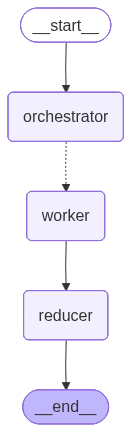

In [30]:
app = g.compile()
app

In [31]:
out = app.invoke({"topic": "Write a blog on Self Attention", "sections": []})

Saved file: C:\Users\Lucky\OneDrive\Desktop\AI\Blog Genrator\outputs\understanding_self-attention_the_key_to_modern_nlp.md
Size: 17970


In [32]:
out

{'topic': 'Write a blog on Self Attention',
 'plan': Plan(blog_title='Understanding Self-Attention: The Key to Modern NLP', tasks=[Task(id=1, title='Introduction to Self-Attention', brief='Define self-attention and its significance in natural language processing (NLP). Discuss its role in transforming how models understand context.'), Task(id=2, title='How Self-Attention Works', brief='Explain the mechanics of self-attention, including the concepts of queries, keys, and values. Use diagrams or examples to illustrate the process.'), Task(id=3, title='Self-Attention vs. Traditional Attention Mechanisms', brief='Compare and contrast self-attention with traditional attention mechanisms. Highlight the advantages of self-attention in handling long-range dependencies.'), Task(id=4, title='Applications of Self-Attention in NLP', brief='Explore various applications of self-attention in NLP tasks such as translation, summarization, and sentiment analysis. Provide examples of models that utilize 